In [33]:
import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
# Define paths

data_root_dir = '../datasets'

In [60]:
# Create dataset
train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

test_dataset[9999][0].shape

torch.Size([1, 28, 28])

In [4]:
print("dimension of training set: ",len(train_dataset))
print("dimension of test set: ",len(test_dataset))

dimension of training set:  60000
dimension of test set:  10000


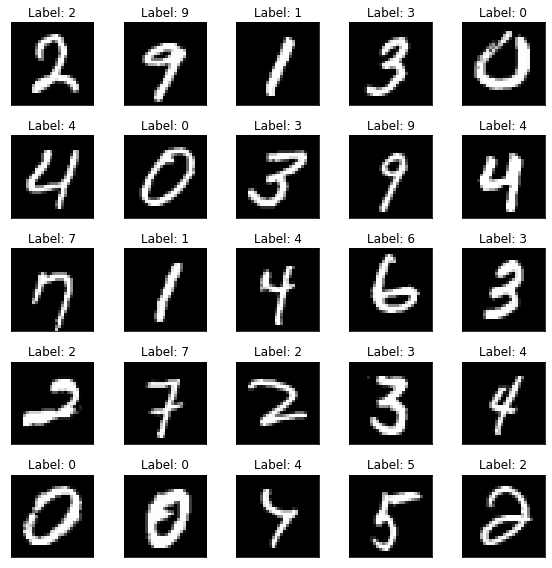

In [5]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()



In [6]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [7]:
### Initialize the network
encoded_space_dim = 6
net = Autoencoder(encoded_space_dim=encoded_space_dim)


### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 6])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [8]:
#%% Prepare training

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

### Define a loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.to(device)

Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvT

In [39]:
#%% Network training

### Training function
def train_epoch(net, dataloader, loss_fn, optimizer):
    # Training
    net.train()
    loss_to_save=[]
    for sample_batch in dataloader:
        # Extract data and move tensors to the selected device
        image_batch = sample_batch[0].to(device)
        # Forward pass
        output = net(image_batch)
        loss = loss_fn(output, image_batch)
        loss_to_save.append(loss)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))
    return loss_to_save


### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out.cpu()])
            conc_label = torch.cat([conc_label, image_batch.cpu()]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

def Evaluation(net,dataset,loss_fn):
    net.eval()
    loss_test=[]
    i=0
    for image in dataset:
            img = image[0].unsqueeze(0).to(device)
            with torch.no_grad():
                out = net(img)
                loss = loss_fn(out, img)
                loss_test.append(loss)
                #plt.figure(figsize=(12,10))
                #plt.imshow(out.squeeze().numpy(), cmap='gist_gray')
                #plt.show()
    return loss_test
    

EPOCH 1/5


	 VALIDATION - EPOCH 1/5 - loss: 0.069230




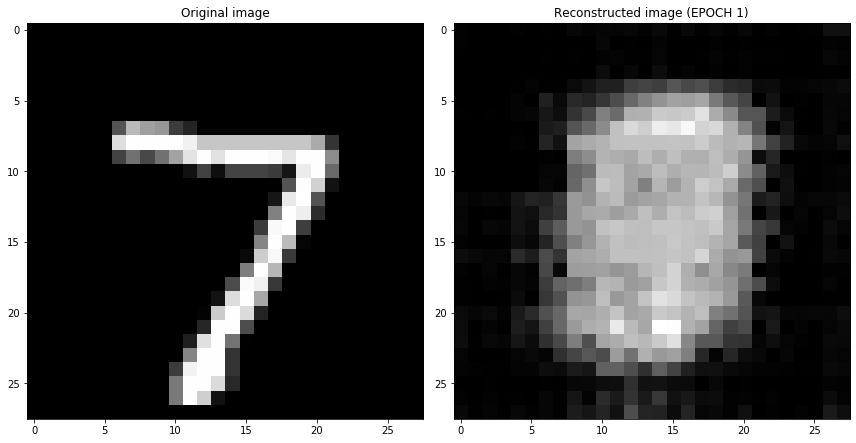

<Figure size 432x288 with 0 Axes>

EPOCH 2/5


	 VALIDATION - EPOCH 2/5 - loss: 0.066576




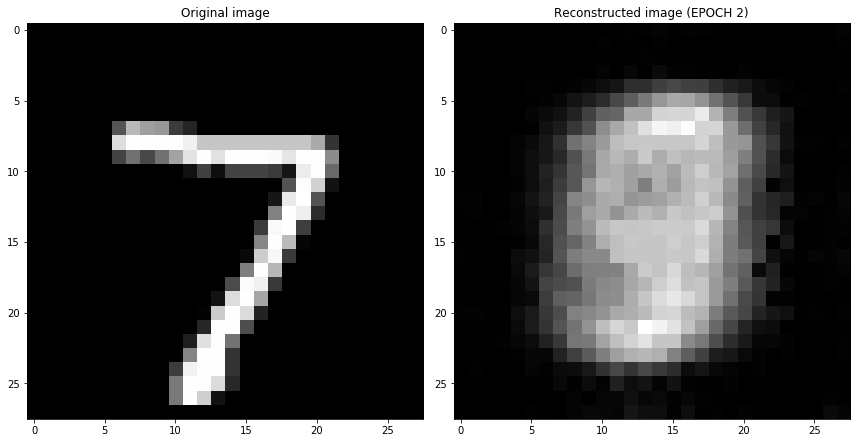

<Figure size 432x288 with 0 Axes>

EPOCH 3/5


	 VALIDATION - EPOCH 3/5 - loss: 0.061292




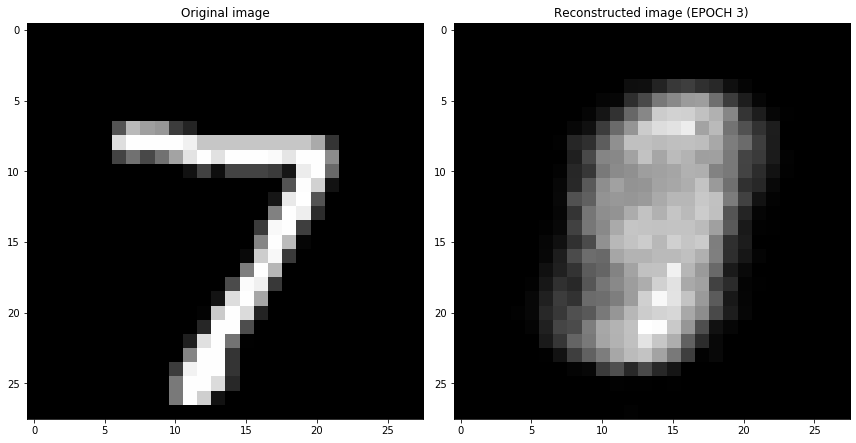

<Figure size 432x288 with 0 Axes>

EPOCH 4/5


	 VALIDATION - EPOCH 4/5 - loss: 0.053070




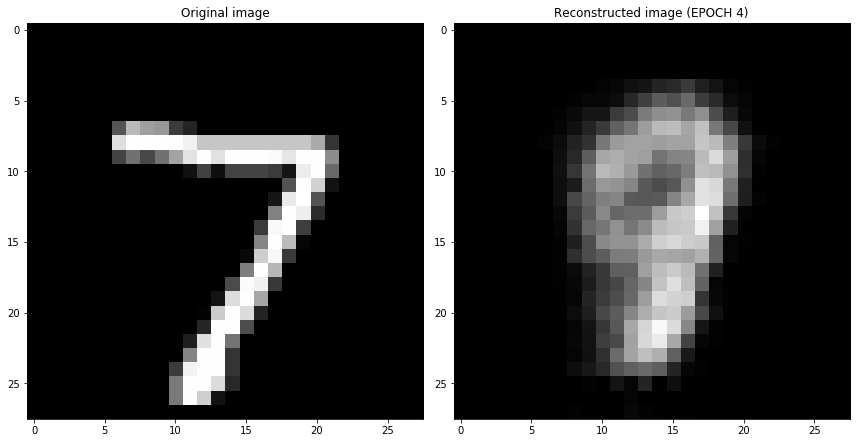

<Figure size 432x288 with 0 Axes>

EPOCH 5/5


	 VALIDATION - EPOCH 5/5 - loss: 0.041930




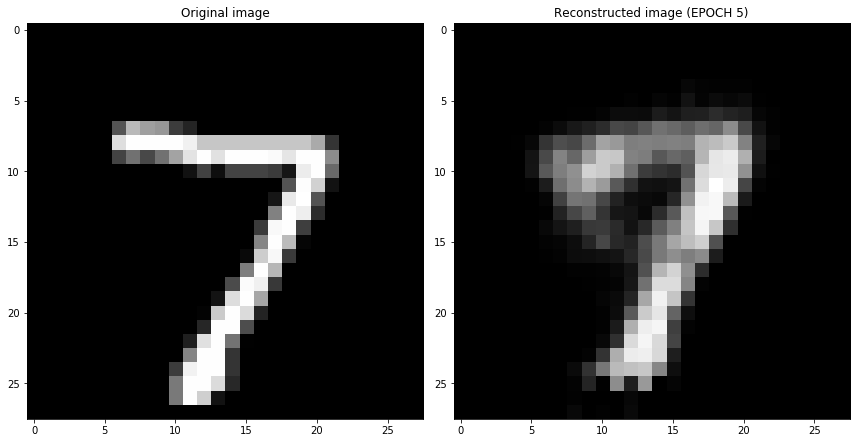

<Figure size 432x288 with 0 Axes>

In [10]:
### Training cycle
training = True
num_epochs = 5
training_loss=[]
validation_loss=[]
if training:
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        loss_iter= train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)
        training_loss.append(loss_iter[-1])
        ### Validation
        val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
        validation_loss.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        img = test_dataset[0][0].unsqueeze(0).to(device)
        net.eval()
        with torch.no_grad():
            rec_img  = net(img)
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(net.state_dict(), 'net_params.pth')



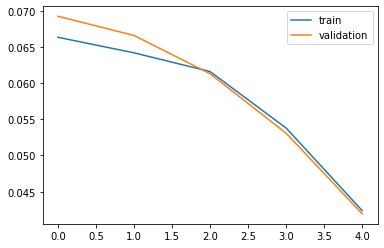

In [11]:
plt.plot(training_loss,label="train")
plt.plot(validation_loss,label="validation")
plt.legend()
plt.show()

In [40]:
loss_test= Evaluation(net,test_dataset,loss_fn=loss_fn)
print(np.mean(loss_test))
    

0.041929986


100%|██████████| 1000/1000 [00:01<00:00, 827.87it/s]


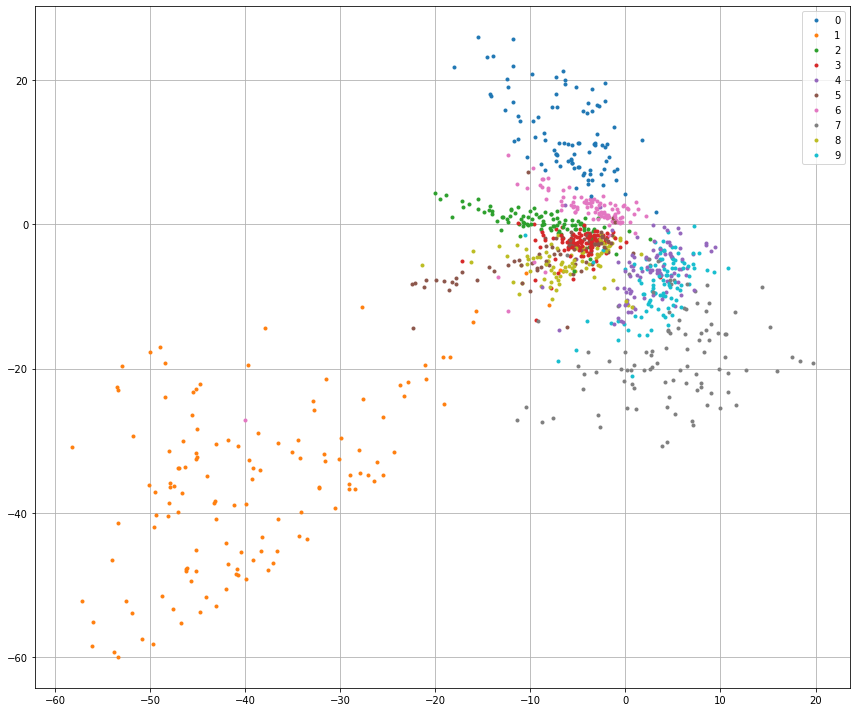

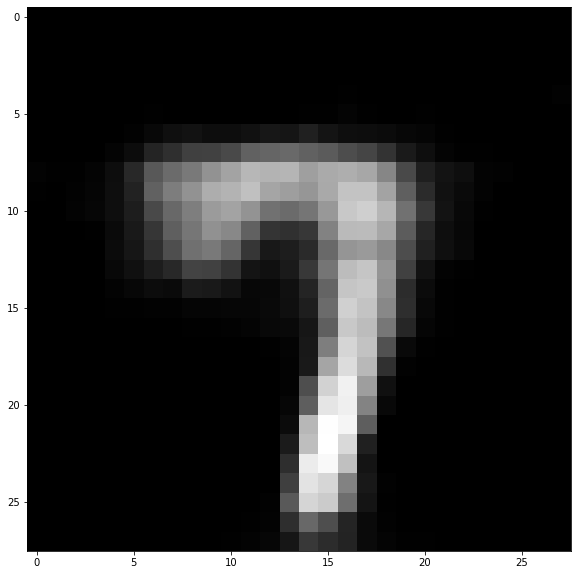

In [18]:
#%% Network analysis

encoded_space_dim = 2
net = Autoencoder(encoded_space_dim=encoded_space_dim)
net.load_state_dict(torch.load('net_params_2.pth', map_location='cpu'))   

### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    # Append to list
    encoded_samples.append((encoded_img.flatten().numpy(), label))
    

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }
    
# Plot just 1k points
encoded_samples_reduced = random.sample(encoded_samples, 1000)
plt.figure(figsize=(12,10))
for enc_sample, label in tqdm(encoded_samples_reduced):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
plt.tight_layout()
plt.show()
        
if encoded_space_dim == 2:
    #%% Generate samples

    encoded_value = torch.tensor([8.0, -12.0]).float().unsqueeze(0)

    net.eval()
    with torch.no_grad():
        new_img  = net.decode(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(new_img.squeeze().numpy(), cmap='gist_gray')
    plt.show()

